In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle 
import tensorflow as tf


import tensorflow.compat.v1 as tf1


from tensorflow.python.keras.layers import  Input, Embedding, Dot, Reshape, Dense
from tensorflow.python.keras.models import Model

#from tensorflow.python.framework import ops



from tqdm import tqdm

#from tqdm.notebook import tqdm

from scipy.spatial.distance import hamming , cosine, euclidean



tf1.disable_v2_behavior()

%matplotlib inline 

Instructions for updating:
non-resource variables are not supported in the long term


# step 1 Dataset utils & preprocessing

In [2]:
def image_loader(image_path , image_size):
    '''
    Load an image from a disk 
    
    :param image_path : String , path to image
    :param image_size : tuple , size of an output image Example : image_size = (32,32)
    
    '''
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    
    image  = cv2.resize(image , image_size , cv2.INTER_CUBIC ) 
    
    return image

In [3]:
def dataset_preprocessing(dataset_path , labels_file_path , image_size , image_paths_pickle):
    '''
    Loads images & labels from dataset folder
    
    :param dataset_path : String , path to train/test dataset folder
    :param labels_file_path : String , path to the .txt file where classes names are written
    :param image_size : tuple , single image size
    :param image_paths_pickle : String , name of a pickle file where all image paths will be saved 
    
    '''
    with open(labels_file_path , "r") as f:
        classes = f.read().split("\n")[:-1]
        
    images = []
    labels = []
    image_paths = []
    
    for image_name in os.listdir(dataset_path):
        try:
            image_path = os.path.join(dataset_path , image_name)
            images.append(image_loader(image_path , image_size))
            image_paths.append(image_path)
            
            for idx in range(len(classes)):
                if classes[idx] in image_name: #EG : 0_frog.png
                    labels.append(idx)
            
        except:
            pass
    
    with open(image_paths_pickle + ".pickle" , "wb") as f:        
        pickle.dump(image_paths , f)
    
    assert len(images) == len(labels)
    return np.array(images) , np.array(labels)    

In [4]:
images , labels = dataset_preprocessing("dataset\\train",
                                        "dataset\\labels.txt",
                                        (32,32),
                                        "training_images_pickle")

In [5]:
images.shape

(50000, 32, 32, 3)

# step 2 : Utils Function

In [ ]:
def cosine_distance(training_set_vectors , query_vector , top_n = 50):
    '''
    Calculates cosine distance b/w query image (vector) and all training set images (vectors)
    
    :param training_set_vectors: numpy Matrix , vectors for all images in the training set
    :param query_vector : numpy Vector , query image (new image) vector
    :param top_n : integer , number of closest images to return 
    
    '''
    distances = []
    
    for i in range(len(training_set_vectors)): # for cifar-10 Dataset -> 50k images
        distances.append(cosine(training_set_vectors[i] , query_vector[0]))
    
    return np.argsort(distances)[:top_n]   

In [7]:
def hamming_distance(training_set_vectors , query_vector , top_n = 50):
    '''
     Calculates hamming distances b/w query image (vector) and all training set images (vectors)
    
    :param training_set_vectors: numpy Matrix , vectors for all images in the training set
    :param query_vector : numpy Vector , query image (new image) vector
    :param top_n : integer , number of closest images to return 
    
    '''
    distances = []
    
    for i in range(len(training_set_vectors)): # for cifar-10 Dataset -> 50k images
        distances.append(hamming(training_set_vectors[i] , query_vector[0]))
    
    return np.argsort(distances)[:top_n]  

In [8]:
def sparse_accuracy(true_labels , predicted_labels):
    '''
    Calculates accuracy of a model based on softmax outputs
    
    :param true_labels : numpy array . real labels of each sample. eg: [1,2,1,0,0]
    :param predicted_labels : numpy matrix , softmax probabilities. Eg. [[02 , 0.1, 0.7] , [0.9 , 0.05 , 0.05]]
    '''
    
    assert len(true_labels) == len(predicted_labels)
    
    correct  = 0
    
    for i in range(len(true_labels)):
        
        if np.argmax(predicted_labels[i]) == true_labels[i]:
            
            correct += 1
            
    return correct / len(true_labels)

# step 3 Model Utils

In [9]:
def model_inputs(image_size):
    '''
    Defines CNN inputs (placeholders)
    
    :param image_size : tuple , (height , width) of an  image
    '''
    # -> [Batch_size , image_size[0] , image_size[1] , 3]
    inputs  = tf1.placeholder(dtype = tf.float32 , shape=[None , image_size[0] , image_size[1] , 3] , name='images')
    
    targets = tf1.placeholder(dtype = tf.int32 , shape = [None] , name='targets')
    dropout_rate = tf1.placeholder(dtype = tf.float32 , name='dropout_rate')
    
    
    return inputs , targets , dropout_rate

In [10]:
def conv_block(inputs , 
               number_of_filters,
               kernel_size ,
               strides = (1,1),
               padding = 'SAME',
               activation = tf.nn.relu ,
               max_pool = True ,
               batch_norm = True ):
    
    
    '''
    Defines Convolutional block layer
    
    :param inputs: data from a previous layer
    :param number_0f_filters : integer , number of conv filters
    :param kernel_size : tuple , size of conv layer kernel
    :param padding : string , type of padding technique : SAME or VALID
    :param activation : tf.object , activation function used on layer 
    :param max_pool : boolean , if true the conv block will use max_pool
    :param batch_norm : boolean , if true the conv block will use batch normalization
      
    '''
    
    conv_features = layer  = tf1.layers.conv2d( inputs = inputs , 
                                               filters = number_of_filters, 
                                               kernel_size = kernel_size ,
                                               strides = strides ,
                                               padding  = padding ,
                                               activation = activation 
                                             )
    
    
    if max_pool:
        
        layer = tf1.layers.max_pooling2d(layer , pool_size = (2,2) , strides=(2, 2) , padding = 'SAME' )
        
    if batch_norm:
        layer = tf1.layers.batch_normalization(layer)
        
    return layer , conv_features

In [11]:
def dense_block(inputs,
                units,
                activation = tf.nn.relu ,
                dropout_rate = None ,
                batch_norm = True):
    '''
    Defines dense block layer
    
    :param inputs : data from a previous layer
    :param units : Integer , number of neurons/units for a dense layer
    :param activation : tf.object , activation function used on layer 
    :param dropout_rate : dropout rate used in this dense block
    :param batch_norm : boolean , if true the conv block will use batch normalization
    
    '''
    dense_features = layer = tf1.layers.dense(inputs = inputs ,
                                             units = units ,
                                             activation = activation )
    
    if dropout_rate is not None:
        layer = tf1.layers.dropout(layer , rate = dropout_rate )
        
    if batch_norm :
        layer = tf1.layers.batch_normalization(layer)
        
    return layer , dense_features

In [12]:
def opt_loss(logits , targets , learning_rate):
    '''
    Define model's optimizer and loss function
    
    :param logits: pre-activated model outputs
    :param targets : true labels for each input sample
    :param learning_rate : learning_rate
    '''
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = targets , logits = logits))
    
    optimizer = tf1.train.AdamOptimizer(learning_rate).minimize(loss)
    
    #tf.optimizers.Adam
    #tf.train.AdamOptimizer
    
    return loss , optimizer

In [13]:
class ImageSearchModel(object):
    
    def __init__(self ,
                 learning_rate ,
                 image_size ,
                 number_of_classes = 10 ): 
        '''
        Define CNN Model 
        
        :param learning_rate : learning_rate
        :param image_size : tuple , (height , width) of an image
        :param number_of_classes : integer , number of classes in dataset
        '''
        
        #tf.reset_default_graph()
        
        tf.compat.v1.reset_default_graph()
        #ops.reset_default_graph()
        
        self.inputs , self.targets , self.dropout_rate = model_inputs(image_size)
        
        normalized_images = tf1.layers.batch_normalization(self.inputs)
        
        #conv block 1
        
        conv_block_1 , self.conv_1_features = conv_block(inputs = normalized_images,
                                                         number_of_filters = 64 , 
                                                         kernel_size = (3,3) , 
                                                         strides=(1,1) , 
                                                         padding = 'SAME' ,
                                                         activation = tf.nn.relu ,
                                                         max_pool = True ,
                                                         batch_norm = True) 
        
        
        #conv block 2
        
        conv_block_2 , self.conv_2_features = conv_block(inputs = conv_block_1 ,
                                                         number_of_filters = 128 , 
                                                         kernel_size = (3,3) , 
                                                         strides=(1,1) , 
                                                         padding = 'SAME' ,
                                                         activation = tf.nn.relu ,
                                                         max_pool = True ,
                                                         batch_norm = True) 
        
        
        #conv block 3
        
        conv_block_3 , self.conv_3_features = conv_block(inputs = conv_block_2 ,
                                                         number_of_filters = 256 , 
                                                         kernel_size = (5,5) , 
                                                         strides=(1,1) , 
                                                         padding = 'SAME' ,
                                                         activation = tf.nn.relu ,
                                                         max_pool = True ,
                                                         batch_norm = True) 
        
        #conv block 4
        
        conv_block_4 , self.conv_4_features = conv_block(inputs = conv_block_3 ,
                                                         number_of_filters = 512 , 
                                                         kernel_size = (5,5) , 
                                                         strides=(1,1) , 
                                                         padding = 'SAME' ,
                                                         activation = tf.nn.relu ,
                                                         max_pool = True ,
                                                         batch_norm = True) 
        
        
        
        #flattening 
        flat_layer  = tf1.layers.flatten(conv_block_4)
        
        
        # Dense block 1
        
        dense_block_1 , dense_1_features = dense_block(inputs = flat_layer ,
                                                       units = 128 ,
                                                       activation = tf.nn.relu ,
                                                       dropout_rate = self.dropout_rate ,
                                                       batch_norm = True )
        
        
        
        
        
        # Dense block 2
        
        dense_block_2 , self.dense_2_features = dense_block(inputs = dense_block_1 ,
                                                       units = 256 ,
                                                       activation = tf.nn.relu ,
                                                       dropout_rate = self.dropout_rate ,
                                                       batch_norm = True )
        
        
        
        # Dense block 3
        
        dense_block_3 , self.dense_3_features = dense_block(inputs = dense_block_2 ,
                                                       units = 512 ,
                                                       activation = tf.nn.relu ,
                                                       dropout_rate = self.dropout_rate ,
                                                       batch_norm = True )
        
        
        
           
        # Dense block 4
        
        dense_block_4 , self.dense_4_features = dense_block(inputs = dense_block_3 ,
                                                       units = 1024 ,
                                                       activation = tf.nn.relu ,
                                                       dropout_rate = self.dropout_rate ,
                                                       batch_norm = True )
        
        
        
        
        logits = tf1.layers.dense(inputs = dense_block_4 , 
                                 units = number_of_classes , 
                                 activation = None )
        
        
        self.predictions = tf.nn.softmax(logits)
        
        self.loss , self.opt = opt_loss(logits = logits  ,
                                        targets = self.targets ,
                                        learning_rate = learning_rate)

#  Step 4 : Training loop - training the model

In [14]:
def train(model ,
          epochs ,
          drop_rate ,
          batch_size ,
          data ,
          save_dir ,
          saver_delta = 0.15):
    
    '''
    The core training function  , use this function to train a mode.
    
    :param model: CNN model
    :param epochs: integer , number of epochs 
    :param drop_rate: float , dropout_rate
    :param batch_size: integer , number of samples to put through the model at once
    :param data: tuple , train-test data example(X_train , y_train , X_test , y_test)
    :param save_dir: string ,path to a folder where model checkpoints will be saved
    :param saver_delta: float , used to prevent overfitted model to be saved
    '''
    
    X_train , y_train  , X_test , y_test = data
    
    #session 
    
    session = tf.compat.v1.Session()
    session.run(tf.compat.v1.global_variables_initializer())
    
    
    #define saver 
    
    saver = tf.compat.v1.train.Saver()
    
    
    best_test_accuracy = 0
    
    
    #Training loop
    
    for epoch in range(epochs):
        
        train_accuracy = []
        train_loss = []
        
        for ii in tqdm(range(len(X_train) // batch_size )):
            
            start_id = ii * batch_size
            end_id = start_id + batch_size
            
            X_batch = X_train[start_id:end_id]
            y_batch = y_train[start_id:end_id]
            
            feed_dict = {model.inputs:X_batch , 
                         model.targets:y_batch , 
                         model.dropout_rate:drop_rate}
            
            
            _, t_loss , preds_t = session.run([model.opt , model.loss , model.predictions], feed_dict = feed_dict)
            
            train_accuracy.append(sparse_accuracy(y_batch , preds_t))
            train_loss.append(t_loss)
            
        print("Epoch: {}/{}".format(epoch, epochs),  
              " | Training accuracy: {}".format(np.mean(train_accuracy)), 
              " | Training loss: {}".format(np.mean(train_loss)) )
        
        test_accuracy = []
            
        for ii in tqdm(range(len(X_test) // batch_size )):
            
            start_id = ii * batch_size
            end_id = start_id + batch_size
            
            X_batch = X_test[start_id:end_id]
            y_batch = y_test[start_id:end_id]
            
            feed_dict = {model.inputs:X_batch , 
                         model.dropout_rate:0.0}
            
            
            preds_test = session.run(model.predictions, feed_dict = feed_dict)
            
            test_accuracy.append(sparse_accuracy(y_batch , preds_test))
            
        print("Test accuracy: {}".format(np.mean(test_accuracy)))
        
        #saving the model
        
        if np.mean(train_accuracy) > np.mean(test_accuracy):
            
            if np.abs(np.mean(train_accuracy) - np.mean(test_accuracy)) <= saver_delta : 
                
                if np.mean(test_accuracy) >= best_test_accuracy:
                    
                    best_test_accuracy = np.mean(test_accuracy)
                    
                    saver.save(session,"{}/model_epoch_{}.ckpt".format(save_dir , epoch))
                    
    session.close()

# Setting hyperparameters and training the model

In [15]:
epochs = 20
batch_size = 128
learning_rate = 0.001
dropout_rate = 0.6
image_size = (32,32)

In [16]:
X_train , y_train = dataset_preprocessing("dataset/train/",
                                          "dataset/labels.txt",
                                          image_size = image_size , 
                                          image_paths_pickle = "train_images_pickle")

In [17]:
X_train.shape

(50000, 32, 32, 3)

In [18]:
X_test , y_test = dataset_preprocessing("dataset/test/",
                                        "dataset/labels.txt",
                                        image_size = image_size , 
                                        image_paths_pickle = "test_images_pickle")

In [19]:
X_test.shape

(10000, 32, 32, 3)

In [20]:
model = ImageSearchModel(learning_rate = learning_rate ,
                         image_size = image_size )

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


In [21]:
data = (X_train , y_train , X_test , y_test)

In [22]:
train(model , epochs , dropout_rate , batch_size , data , "saver")

  1%|█                                                                                  | 1/78 [00:00<00:08,  8.75it/s]

Epoch: 0/20  | Training accuracy: 0.35496794871794873  | Training loss: 1.8652923107147217


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.5092147435897436


  3%|██▏                                                                                | 2/78 [00:00<00:06, 12.31it/s]

Epoch: 1/20  | Training accuracy: 0.5409054487179488  | Training loss: 1.253285527229309


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.5716145833333334


  3%|██▏                                                                                | 2/78 [00:00<00:05, 12.77it/s]

Epoch: 2/20  | Training accuracy: 0.6188100961538462  | Training loss: 1.0643799304962158


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6276041666666666


  3%|██▏                                                                                | 2/78 [00:00<00:06, 12.61it/s]

Epoch: 3/20  | Training accuracy: 0.6673076923076923  | Training loss: 0.9368583559989929


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.66it/s]


Test accuracy: 0.6634615384615384


  3%|██▏                                                                                | 2/78 [00:00<00:06, 12.53it/s]

Epoch: 4/20  | Training accuracy: 0.7030448717948717  | Training loss: 0.8454976677894592


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6584535256410257


  3%|██▏                                                                                | 2/78 [00:00<00:06, 11.59it/s]

Epoch: 5/20  | Training accuracy: 0.7380408653846153  | Training loss: 0.7490361332893372


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.97it/s]


Test accuracy: 0.6703725961538461


  3%|██▏                                                                                | 2/78 [00:00<00:05, 12.77it/s]

Epoch: 6/20  | Training accuracy: 0.7635016025641026  | Training loss: 0.6725896000862122


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6645633012820513


  3%|██▏                                                                                | 2/78 [00:00<00:06, 12.53it/s]

Epoch: 7/20  | Training accuracy: 0.7869591346153846  | Training loss: 0.6110365390777588


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6493389423076923


  3%|██▏                                                                                | 2/78 [00:00<00:05, 12.94it/s]

Epoch: 8/20  | Training accuracy: 0.8042868589743589  | Training loss: 0.5667721629142761


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6489383012820513


  3%|██▏                                                                                | 2/78 [00:00<00:05, 12.94it/s]

Epoch: 9/20  | Training accuracy: 0.8265625  | Training loss: 0.5048208236694336


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6415264423076923


  3%|██▏                                                                                | 2/78 [00:00<00:06, 12.30it/s]

Epoch: 10/20  | Training accuracy: 0.8482171474358975  | Training loss: 0.44120776653289795


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6431290064102564


  3%|██▏                                                                                | 2/78 [00:00<00:06, 12.16it/s]

Epoch: 11/20  | Training accuracy: 0.8637219551282052  | Training loss: 0.40011143684387207


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6338141025641025


  3%|██▏                                                                                | 2/78 [00:00<00:05, 12.68it/s]

Epoch: 12/20  | Training accuracy: 0.8842948717948718  | Training loss: 0.33911147713661194


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6573517628205128


  3%|██▏                                                                                | 2/78 [00:00<00:05, 13.11it/s]

Epoch: 13/20  | Training accuracy: 0.8985376602564102  | Training loss: 0.3027282655239105


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6372195512820513


  3%|██▏                                                                                | 2/78 [00:00<00:06, 12.46it/s]

Epoch: 14/20  | Training accuracy: 0.9064102564102564  | Training loss: 0.28028011322021484


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6546474358974359


  3%|██▏                                                                                | 2/78 [00:00<00:06, 11.81it/s]

Epoch: 15/20  | Training accuracy: 0.9173477564102565  | Training loss: 0.24275317788124084


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6630608974358975


  3%|██▏                                                                                | 2/78 [00:00<00:05, 13.28it/s]

Epoch: 16/20  | Training accuracy: 0.9263020833333333  | Training loss: 0.21780316531658173


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6829927884615384


  3%|██▏                                                                                | 2/78 [00:00<00:05, 13.03it/s]

Epoch: 17/20  | Training accuracy: 0.936698717948718  | Training loss: 0.18835923075675964


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6727764423076923


  3%|██▏                                                                                | 2/78 [00:00<00:05, 13.08it/s]

Epoch: 18/20  | Training accuracy: 0.9435496794871795  | Training loss: 0.17055046558380127


  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

Test accuracy: 0.6683693910256411


  3%|██▏                                                                                | 2/78 [00:00<00:05, 12.77it/s]

Epoch: 19/20  | Training accuracy: 0.9489383012820513  | Training loss: 0.15734867751598358


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 12.16it/s]


Test accuracy: 0.6681690705128205


# Step 6 Create training set vectors | Define Inference function

In [23]:
def create_training_set_vectors(model,
                                X_train,
                                y_train,
                                batch_size,
                                checkpoint_path,
                                image_size,
                                distance = 'hamming'):
     
    '''
    Creates training set vectors & saves them in a pickle file
    
    :param model: CNN Model
    :param X_train: numpy array , loaded training set images
    :param y_train: numpy array , loaded training set labels
    :param batch_size: integer , number of samples to put through the model at once
    :param checkpoint_path: string , path to the model checkpoint 
    :param image_size: tuple , single image (height , width)
    :param distance: string , type of distance to be used ,
            this parameter is used to choose a way how to prepare & save training set vectors
    
    '''
    
    session = tf.compat.v1.Session()
    session.run(tf.compat.v1.global_variables_initializer())
    
    saver = tf.compat.v1.train.Saver()
    saver.restore(session , checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []
    
    for ii in tqdm(range(len(X_train) // batch_size)):
        
        start_id = ii * batch_size
        end_id = start_id + batch_size
        
        X_batch = X_train[start_id:end_id]
        
        feed_dict = {model.inputs:X_batch , model.dropout_rate:0.0}
        
        dense_2 , dense_4 = session.run([model.dense_2_features, model.dense_4_features],
                                        feed_dict = feed_dict)
        
        
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
    
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    
    
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        training_vectors = np.hstack((dense_2_features , dense_4_features))
        
        with open("hamming_train_vectors.pickle","wb") as f:
            
            pickle.dump(training_vectors , f)
    
    elif distance == "cosine":
        
        
        training_vectors = np.hstack((dense_2_features , dense_4_features))
        
        with open("cosine_train_vectors.pickle","wb") as f:
            
            pickle.dump(training_vectors , f)

In [24]:
def create_training_set_vectors_with_colors(model,
                                            X_train,
                                            y_train,
                                            batch_size,
                                            checkpoint_path,
                                            image_size,
                                            distance='hamming'):
    
    '''
    Creates training set vectors and saves them in a pickle file.
    
    :param model: CNN model
    :param X_train: numpy array, loaded training set images
    :param y_train: numpy array,loaded training set labels
    :param batch_size: integer, number of samples to put trhough the model at once
    :param checkpoint_path: string, path to the model checkpoint
    :param image_size: tuple, single image (height, width)
    :param distance: string, type of distance to be used,
                             this parameter is used to choose a way how to prepare and save training set vectors
    '''
            
    #Define session
    session = tf.compat.v1.Session()
    session.run(tf.compat.v1.global_variables_initializer())
    
    #restore session
    saver = tf.compat.v1.train.Saver()
    saver.restore(session, checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []
    
    ##########################################################################
    ### Calculate color feature vectors for each image in the training set ###
    color_features = []
    for img in X_train:
            channels = cv2.split(img)
            features = []
            for chan in channels:
               hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
               features.append(hist)
            
            color_features.append(np.vstack(features).squeeze())
    ##########################################################################
    
    #iterate through training set
    for ii in tqdm(range(len(X_train) // batch_size)):
             start_id = ii*batch_size
             end_id = start_id + batch_size
 
             X_batch = X_train[start_id:end_id]
 
             feed_dict = {model.inputs:X_batch,
                        model.dropout_rate:0.0}
        
             dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
        
             dense_2_features.append(dense_2)
             dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    #hamming distance - vectors processing
    if distance == 'hamming':
             dense_2_features = np.where(dense_2_features < 0.5, 0, 1) #binarize vectors
             dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
             training_vectors = np.hstack((dense_2_features, dense_4_features))
             with open('hamming_train_vectors.pickle', 'wb') as f:
                 pickle.dump(training_vectors, f)
            
    #cosine distance - vectors processing
    elif distance == 'cosine':
             training_vectors = np.hstack((dense_2_features, dense_4_features))
             training_vectors = np.hstack((training_vectors, color_features[:len(training_vectors)]))
             with open('cosine_train_vectors.pickle', 'wb') as f:
                pickle.dump(training_vectors, f)
            
    #########################################################################
    ### Save training set color feature vectors to a separate pickle file ###
    with open('color_vectors.pickle', 'wb') as f:
              pickle.dump(color_features[:len(training_vectors)], f)
    #########################################################################

In [25]:
model = ImageSearchModel(learning_rate , image_size)

In [26]:
create_training_set_vectors_with_colors(model ,
                            X_train , y_train , 
                            batch_size , 
                            "saver/model_epoch_5.ckpt", 
                            image_size)

INFO:tensorflow:Restoring parameters from saver/model_epoch_5.ckpt


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:28<00:00, 13.79it/s]


In [27]:
def compare_color(color_vectors,
                  uploaded_image_colors,
                  ids):
    '''
    Comparing color vectors of closest images from the training set with a color vector of a uploaded image (query image).
    
    :param color_vectors: color features vectors of closest training set images to the uploaded image
    :param uploaded_image_colors: color vector of the uploaded image
    :param ids: indices of training images being closest to the uploaded image (output from a distance function)
    '''
    color_distances = []
    
    for i in range(len(color_vectors)):
        color_distances.append(euclidean(color_vectors[i], uploaded_image_colors))
        
    #The 15 is just an random number that I have choosen, you can return as many as you need/want
    return ids[np.argsort(color_distances)[:15]]

In [28]:
def simple_inference(model,
                     session,
                     train_set_vectors,
                     uploaded_image_path,
                     image_size,
                     distance = 'hamming'):
    
    
    '''
    Doing simple inference for single uploaded image
    
    :param model: CNN model
    :param session: tf.Session, restored session
    :param train_set_vectors: loaded training set vectors
    :param uploaded_image_path: string, path to the uploaded image
    :param image_size: tuple, single image (height, width)
    :param distance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare vectors
    
    '''
    
    image = image_loader(uploaded_image_path, image_size)
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    
    dense_2_features , dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict = feed_dict)
    
    closest_ids = None
    
    if distance == "hamming":
        
        dense_2_features = np.where(dense_2_features < 0.5 , 0 ,1)
        dense_4_features = np.where(dense_4_features < 0.5 , 0 ,1)                          
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
    elif distance == "cosine":
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
    return closest_ids

In [29]:
def simple_inference_with_color_filters(model,
                                         session,
                                         train_set_vectors,
                                         uploaded_image_path,
                                         color_vectors,
                                         image_size,
                                         distance='hamming'):
    
    '''
    Doing simple inference for single uploaded image.
    
    :param model: CNN model
    :param session: tf.Session, restored session
    :param train_set_vectors: loaded training set vectors
    :param uploaded_image_path: string, path to the uploaded image
    :param color_vectors: loaded training set color features vectors
    :param image_size: tuple, single image (height, width)
    :param distance: string, type of distance to be used,
                             this parameter is used to choose a way how to prepare vectors
    '''
    
    image = image_loader(uploaded_image_path, image_size)
    
    ####################################################
    ## Calculating color histogram of the query image ##
    channels = cv2.split(image)
    features = []
    for chan in channels:
             hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
             features.append(hist)
 
    color_features = np.vstack(features).T
    ####################################################
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
    
    closest_ids = None
    if distance == 'hamming':
            dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
            dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
            uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
            closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
              #Comparing color features between query image and closest images selected by the model
            #################################################
            ## Compare color vectors ########################
            closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    elif distance == 'cosine':
             uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
             closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
             #Comparing color features between query image and closest images selected by the model
           #################################################
           ## Compare color vectors ########################
             closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    return closest_ids

# Pipeline test
## Define session & model

In [30]:
model  = ImageSearchModel(learning_rate = learning_rate , image_size = image_size)

session = tf.compat.v1.Session()
session.run(tf.compat.v1.global_variables_initializer())

# Restore session

In [32]:
saver = tf.compat.v1.train.Saver()
saver.restore(session , "saver/model_epoch_5.ckpt") 

INFO:tensorflow:Restoring parameters from saver/model_epoch_5.ckpt


# Load Training set image paths

In [33]:
with open('train_images_pickle.pickle','rb') as f:
    train_image_paths = pickle.load(f)

In [34]:
train_image_paths[:10]

['dataset/train/0_frog.png',
 'dataset/train/10000_automobile.png',
 'dataset/train/10001_frog.png',
 'dataset/train/10002_frog.png',
 'dataset/train/10003_ship.png',
 'dataset/train/10004_ship.png',
 'dataset/train/10005_cat.png',
 'dataset/train/10006_deer.png',
 'dataset/train/10007_frog.png',
 'dataset/train/10008_airplane.png']

# load training set vectors

In [35]:
with open('hamming_train_vectors.pickle','rb') as f:
    train_set_vectors = pickle.load(f)

In [36]:
with open('color_vectors.pickle', 'rb') as f:
    color_vectors = pickle.load(f)

In [37]:
test_image = 'dataset/test/1052_airplane.png'

## Get closest images - ids

In [38]:
result_ids = simple_inference_with_color_filters(model , 
                                                 session ,
                                                 train_set_vectors, 
                                                 test_image,
                                                 color_vectors,
                                                 image_size,
                                                 distance = 'hamming')

# show query image

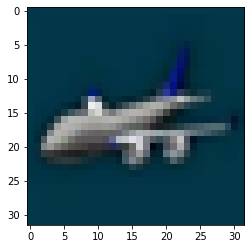

In [39]:
plt.imshow(image_loader(test_image, image_size))

# show result images

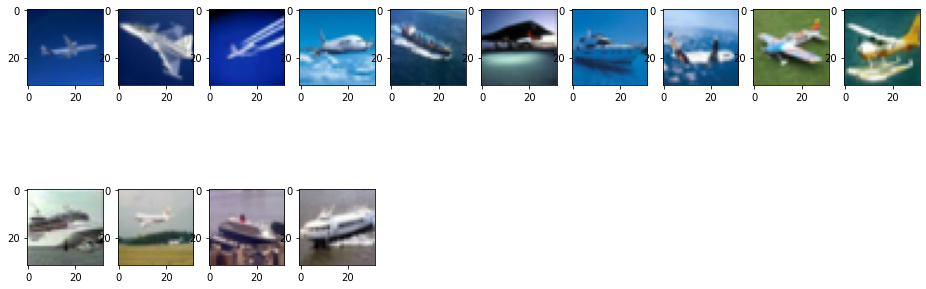

In [40]:
w = 10
h = 10
fig = plt.figure(figsize = (16,16))
colums = 10
rows = 5
for i in range(1, colums*rows+1):
    try:
        image = image_loader(train_image_paths[result_ids[i]], image_size)
        fig.add_subplot(rows , colums, i)
        plt.imshow(image)
    except:
        pass
plt.show()